In [1]:
!pip install efficientnet-pytorch

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import time
import torch
torch.set_num_threads(36)
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from efficientnet_pytorch import EfficientNet
from senet import se_resnext50_32x4d
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

from radam import RAdam
from lookahead import Lookahead

METADATA_DIR = 'data/metadata'
FACES_DIR = 'faces_saved'

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
%%time

with open('dev_faces.pickle', 'rb') as handle:
    dev_faces = pickle.load(handle)
    
with open('test_faces.pickle', 'rb') as handle:
    test_faces = pickle.load(handle)
    
with open('dev_target.pickle', 'rb') as handle:
    dev_target = pickle.load(handle)
    
with open('test_target.pickle', 'rb') as handle:
    test_target = pickle.load(handle)

len(dev_faces), len(test_faces), len(dev_target), len(test_target)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.59 ms


(10792, 10803, 10792, 10803)

In [4]:
dev_videos = [x.split('/')[1] + '.mp4' for x in dev_faces]
test_videos = [x.split('/')[1] + '.mp4' for x in test_faces]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, faces_paths, faces_labels, datatype='train', transform=None):
        self.faces_paths = faces_paths
        self.datatype = datatype
        assert self.datatype in ['train', 'dev', 'test', 'inference']
        self.labels = faces_labels
        self.transform = transform

    def __len__(self):
        return len(self.faces_paths)

    def __getitem__(self, idx):
        img_name = self.faces_paths[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
#             img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            img = self.transform(img / 255)
#             img = img.permute(2, 0, 1)
        else:
            img = np.transpose(img, (2, 0, 1)) / 255

        if self.datatype != 'inference':
            label = self.labels[idx]
            return img, label
        else:
            return img

In [6]:
batch_size = 64
num_workers = 8

In [7]:
def prepare_model(checkpoint, device=device, model_name='efficientnet-b4', num_classes=2):
    if model_name.startswith('efficient'):
        model = EfficientNet.from_name(model_name)
        in_features = model._fc.in_features
        model._fc = nn.Linear(in_features, num_classes)
    elif model_name == 'se_resnext50':
        model = se_resnext50_32x4d(num_classes=1000, pretrained=None)
        in_features = model.last_linear.in_features
        model.last_linear = nn.Linear(in_features, num_classes)
    else:
        raise NotImplementedError("To be implemented")
    model.load_state_dict(checkpoint)
    model.to(device=device)
    _ = model.eval()
    return model

# 1. EfficientNet-B4

##### (2020-03-03_07-25-04_efficientnet-b4-radam-lookahead-baseline_994682_ep4.pt)

In [8]:
%%time

checkpoint_name = '2020-03-03_07-25-04_efficientnet-b4-radam-lookahead-baseline_994682_ep4.pt'
checkpoint = torch.load(os.path.join('models_checkpoints', checkpoint_name), map_location=device)

custom_transforms = transforms.Compose([
#     transforms.Resize((224,224)), 
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev', transform=custom_transforms)
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test', transform=custom_transforms)

dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

y_dev_pred = np.zeros(len(dataset_dev))
y_test_pred = np.zeros(len(dataset_test))

model = prepare_model(checkpoint)
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(dev_loader, desc='dev')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_dev_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(test_loader, desc='test')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_test_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

test: 100%|██████████| 169/169 [00:36<00:00,  4.59it/s]

CPU times: user 57.5 s, sys: 18 s, total: 1min 15s
Wall time: 1min 17s


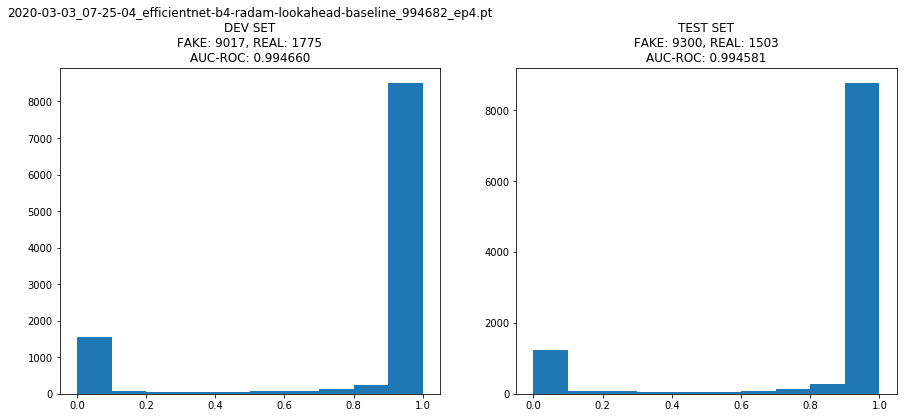

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].set_title('{}\nDEV SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    checkpoint_name,
    (y_dev_pred > 0.5).sum(),
    (y_dev_pred <= 0.5).sum(),
    roc_auc_score(dev_target, y_dev_pred)
))
ax[0].hist(y_dev_pred, bins=10)

ax[1].set_title('TEST SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    (y_test_pred > 0.5).sum(),
    (y_test_pred <= 0.5).sum(),
    roc_auc_score(test_target, y_test_pred)
))
ax[1].hist(y_test_pred, bins=10)

plt.show()

In [10]:
df_dev_pred = pd.DataFrame({'filename': dev_videos, 'prediction': y_dev_pred, 'target': dev_target})
df_dev_pred = df_dev_pred.groupby('filename').mean().reset_index()
df_test_pred = pd.DataFrame({'filename': test_videos, 'prediction': y_test_pred, 'target': test_target})
df_test_pred = df_test_pred.groupby('filename').mean().reset_index()
roc_auc_score(df_dev_pred['target'], df_dev_pred['prediction']), roc_auc_score(df_test_pred['target'], df_test_pred['prediction'])

(0.9980714107842047, 0.9986441052321586)

In [11]:
df_dev_pred.head()

,filename,prediction,target
0,aakdoghgcp.mp4,0.985469,1
1,aatntbvzum.mp4,0.130444,0
2,acdlfavijf.mp4,0.999233,1
3,acffugkzgj.mp4,0.999994,1
4,acozboebwm.mp4,0.602908,0


In [12]:
df_test_pred.head()

,filename,prediction,target
0,aaeflzzhvy.mp4,0.999989,1
1,aafkeenkqm.mp4,0.998493,1
2,abhssqzhxu.mp4,0.555657,0
3,ablakozzyi.mp4,0.999989,1
4,ablzgowmwo.mp4,0.294504,0


In [13]:
df_dev_pred.to_csv('results_DEV/DEV_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))
df_test_pred.to_csv('results_TEST/TEST_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))

# 2. EfficientNet-B4 (undersampling)

##### (2020-03-12_12-20-58_efficientnet-b4-radam-lookahead-baseline-undersampling_995090_ep3.pt)

In [14]:
%%time

checkpoint_name = '2020-03-12_12-20-58_efficientnet-b4-radam-lookahead-baseline-undersampling_995090_ep3.pt'
checkpoint = torch.load(os.path.join('models_checkpoints', checkpoint_name), map_location=device)

custom_transforms = transforms.Compose([
#     transforms.Resize((224,224)), 
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev', transform=custom_transforms)
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test', transform=custom_transforms)

dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

y_dev_pred = np.zeros(len(dataset_dev))
y_test_pred = np.zeros(len(dataset_test))

model = prepare_model(checkpoint)
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(dev_loader, desc='dev')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_dev_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(test_loader, desc='test')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_test_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

test: 100%|██████████| 169/169 [00:36<00:00,  4.58it/s]

CPU times: user 55.8 s, sys: 16.3 s, total: 1min 12s
Wall time: 1min 15s


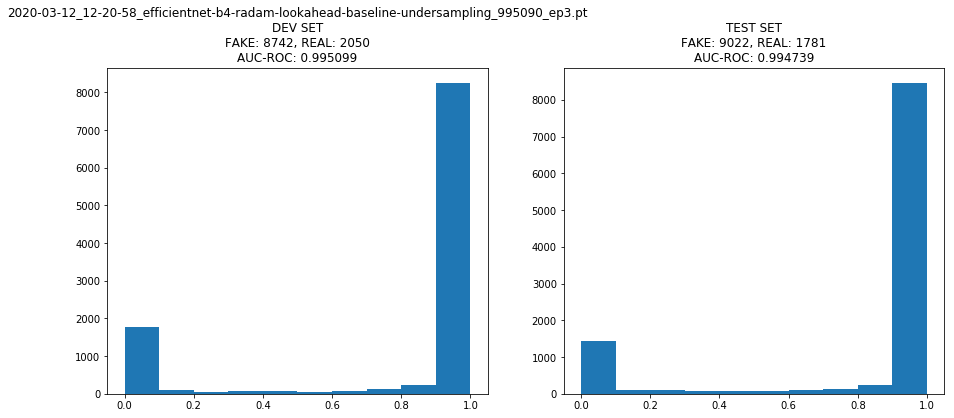

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].set_title('{}\nDEV SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    checkpoint_name,
    (y_dev_pred > 0.5).sum(),
    (y_dev_pred <= 0.5).sum(),
    roc_auc_score(dev_target, y_dev_pred)
))
ax[0].hist(y_dev_pred, bins=10)

ax[1].set_title('TEST SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    (y_test_pred > 0.5).sum(),
    (y_test_pred <= 0.5).sum(),
    roc_auc_score(test_target, y_test_pred)
))
ax[1].hist(y_test_pred, bins=10)

plt.show()

In [16]:
df_dev_pred = pd.DataFrame({'filename': dev_videos, 'prediction': y_dev_pred, 'target': dev_target})
df_dev_pred = df_dev_pred.groupby('filename').mean().reset_index()
df_test_pred = pd.DataFrame({'filename': test_videos, 'prediction': y_test_pred, 'target': test_target})
df_test_pred = df_test_pred.groupby('filename').mean().reset_index()
roc_auc_score(df_dev_pred['target'], df_dev_pred['prediction']), roc_auc_score(df_test_pred['target'], df_test_pred['prediction'])

(0.9979389527336693, 0.99916560321979)

In [17]:
df_dev_pred.head()

,filename,prediction,target
0,aakdoghgcp.mp4,0.716145,1
1,aatntbvzum.mp4,0.128722,0
2,acdlfavijf.mp4,0.952975,1
3,acffugkzgj.mp4,0.999995,1
4,acozboebwm.mp4,0.351408,0


In [18]:
df_test_pred.head()

,filename,prediction,target
0,aaeflzzhvy.mp4,0.999993,1
1,aafkeenkqm.mp4,0.993685,1
2,abhssqzhxu.mp4,0.315384,0
3,ablakozzyi.mp4,0.975139,1
4,ablzgowmwo.mp4,0.140292,0


In [19]:
df_dev_pred.to_csv('results_DEV/DEV_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))
df_test_pred.to_csv('results_TEST/TEST_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))

# 3. EfficientNet-B4 (undersampling)

##### (2020-03-12_15-55-44_efficientnet-b4-radam-lookahead-baseline-undersampling_995658_ep4.pt)

In [20]:
%%time

checkpoint_name = '2020-03-12_15-55-44_efficientnet-b4-radam-lookahead-baseline-undersampling_995658_ep4.pt'
checkpoint = torch.load(os.path.join('models_checkpoints', checkpoint_name), map_location=device)

custom_transforms = transforms.Compose([
#     transforms.Resize((224,224)), 
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev', transform=custom_transforms)
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test', transform=custom_transforms)

dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

y_dev_pred = np.zeros(len(dataset_dev))
y_test_pred = np.zeros(len(dataset_test))

model = prepare_model(checkpoint)
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(dev_loader, desc='dev')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_dev_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(test_loader, desc='test')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_test_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

test: 100%|██████████| 169/169 [00:36<00:00,  4.59it/s]

CPU times: user 55.2 s, sys: 16.7 s, total: 1min 11s
Wall time: 1min 14s


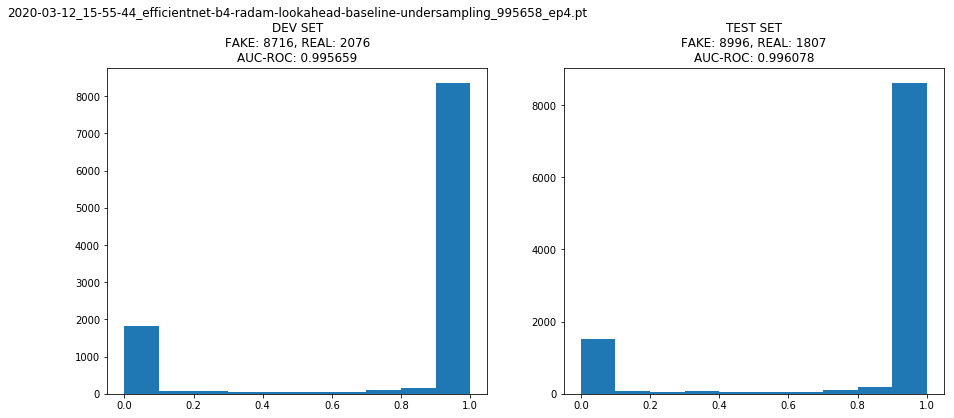

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].set_title('{}\nDEV SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    checkpoint_name,
    (y_dev_pred > 0.5).sum(),
    (y_dev_pred <= 0.5).sum(),
    roc_auc_score(dev_target, y_dev_pred)
))
ax[0].hist(y_dev_pred, bins=10)

ax[1].set_title('TEST SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    (y_test_pred > 0.5).sum(),
    (y_test_pred <= 0.5).sum(),
    roc_auc_score(test_target, y_test_pred)
))
ax[1].hist(y_test_pred, bins=10)

plt.show()

In [22]:
df_dev_pred = pd.DataFrame({'filename': dev_videos, 'prediction': y_dev_pred, 'target': dev_target})
df_dev_pred = df_dev_pred.groupby('filename').mean().reset_index()
df_test_pred = pd.DataFrame({'filename': test_videos, 'prediction': y_test_pred, 'target': test_target})
df_test_pred = df_test_pred.groupby('filename').mean().reset_index()
roc_auc_score(df_dev_pred['target'], df_dev_pred['prediction']), roc_auc_score(df_test_pred['target'], df_test_pred['prediction'])

(0.9979813393098406, 0.9987790811818986)

In [23]:
df_dev_pred.head()

,filename,prediction,target
0,aakdoghgcp.mp4,0.849930,1
1,aatntbvzum.mp4,0.002464,0
2,acdlfavijf.mp4,0.989828,1
3,acffugkzgj.mp4,0.999994,1
4,acozboebwm.mp4,0.176879,0


In [24]:
df_test_pred.head()

,filename,prediction,target
0,aaeflzzhvy.mp4,0.999996,1
1,aafkeenkqm.mp4,0.999579,1
2,abhssqzhxu.mp4,0.174179,0
3,ablakozzyi.mp4,0.999857,1
4,ablzgowmwo.mp4,0.132307,0


In [25]:
df_dev_pred.to_csv('results_DEV/DEV_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))
df_test_pred.to_csv('results_TEST/TEST_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))

# 4. EfficientNet-B3 (undersampling + normalized)

##### (2020-03-14_07-37-44_efficientnet-b3-radam-lookahead-baseline-undersampling_994986_ep3.pt)

In [38]:
%%time

checkpoint_name = '2020-03-14_07-37-44_efficientnet-b3-radam-lookahead-baseline-undersampling_994986_ep3.pt'
checkpoint = torch.load(os.path.join('models_checkpoints', checkpoint_name), map_location=device)

custom_transforms = transforms.Compose([
#     transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev', transform=custom_transforms)
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test', transform=custom_transforms)

dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

y_dev_pred = np.zeros(len(dataset_dev))
y_test_pred = np.zeros(len(dataset_test))

model = prepare_model(checkpoint, model_name='efficientnet-b3')
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(dev_loader, desc='dev')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_dev_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(test_loader, desc='test')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_test_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

test: 100%|██████████| 169/169 [00:29<00:00,  5.74it/s]

CPU times: user 43.6 s, sys: 12.5 s, total: 56.1 s
Wall time: 59.2 s


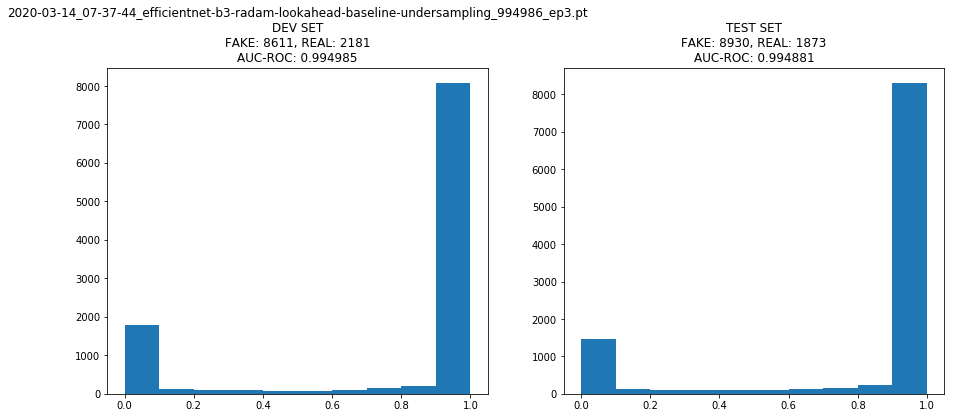

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].set_title('{}\nDEV SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    checkpoint_name,
    (y_dev_pred > 0.5).sum(),
    (y_dev_pred <= 0.5).sum(),
    roc_auc_score(dev_target, y_dev_pred)
))
ax[0].hist(y_dev_pred, bins=10)

ax[1].set_title('TEST SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    (y_test_pred > 0.5).sum(),
    (y_test_pred <= 0.5).sum(),
    roc_auc_score(test_target, y_test_pred)
))
ax[1].hist(y_test_pred, bins=10)

plt.show()

In [40]:
df_dev_pred = pd.DataFrame({'filename': dev_videos, 'prediction': y_dev_pred, 'target': dev_target})
df_dev_pred = df_dev_pred.groupby('filename').mean().reset_index()
df_test_pred = pd.DataFrame({'filename': test_videos, 'prediction': y_test_pred, 'target': test_target})
df_test_pred = df_test_pred.groupby('filename').mean().reset_index()
roc_auc_score(df_dev_pred['target'], df_dev_pred['prediction']), roc_auc_score(df_test_pred['target'], df_test_pred['prediction'])

(0.9983893101054896, 0.9984723176597624)

In [41]:
df_dev_pred.head()

,filename,prediction,target
0,aakdoghgcp.mp4,0.728406,1
1,aatntbvzum.mp4,0.001936,0
2,acdlfavijf.mp4,0.993654,1
3,acffugkzgj.mp4,0.999999,1
4,acozboebwm.mp4,0.147604,0


In [42]:
df_test_pred.head()

,filename,prediction,target
0,aaeflzzhvy.mp4,1.000000,1
1,aafkeenkqm.mp4,0.985782,1
2,abhssqzhxu.mp4,0.060892,0
3,ablakozzyi.mp4,0.999937,1
4,ablzgowmwo.mp4,0.072566,0


In [43]:
df_dev_pred.to_csv('results_DEV/DEV_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))
df_test_pred.to_csv('results_TEST/TEST_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))

# 5. SE-ResNext-50 (undersampling + normalized)

##### (2020-03-16_08-08-14_se-resnext-50-radam-lookahead-baseline-undersampling-normalized_995047_ep4.pt)

In [8]:
%%time

checkpoint_name = '2020-03-16_08-08-14_se-resnext-50-radam-lookahead-baseline-undersampling-normalized_995047_ep4.pt'
checkpoint = torch.load(os.path.join('models_checkpoints', checkpoint_name), map_location=device)

custom_transforms = transforms.Compose([
#     transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev', transform=custom_transforms)
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test', transform=custom_transforms)

dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

y_dev_pred = np.zeros(len(dataset_dev))
y_test_pred = np.zeros(len(dataset_test))

model = prepare_model(checkpoint, model_name='se_resnext50')
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(dev_loader, desc='dev')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_dev_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(test_loader, desc='test')):
        data, target = data.to(device=device).float(), target.to(device=device)
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        y_test_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()

test: 100%|██████████| 169/169 [00:35<00:00,  4.73it/s]

CPU times: user 54.8 s, sys: 17.8 s, total: 1min 12s
Wall time: 1min 20s


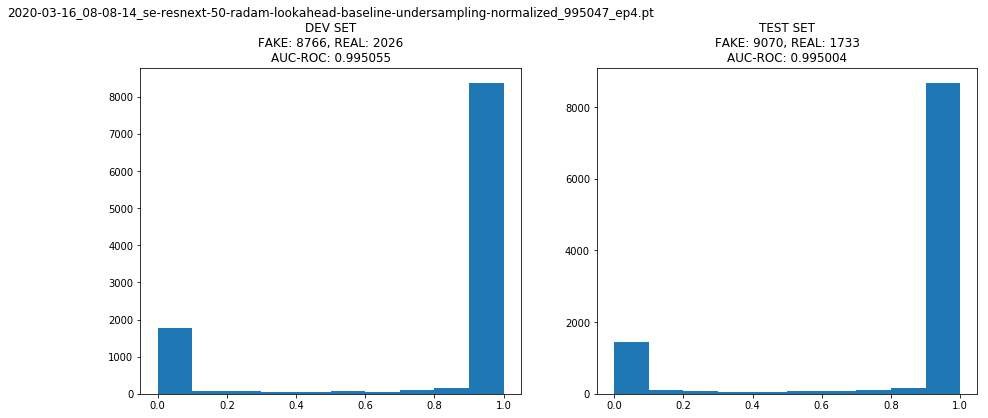

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].set_title('{}\nDEV SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    checkpoint_name,
    (y_dev_pred > 0.5).sum(),
    (y_dev_pred <= 0.5).sum(),
    roc_auc_score(dev_target, y_dev_pred)
))
ax[0].hist(y_dev_pred, bins=10)

ax[1].set_title('TEST SET\nFAKE: {}, REAL: {}\nAUC-ROC: {:.6f}'.format(
    (y_test_pred > 0.5).sum(),
    (y_test_pred <= 0.5).sum(),
    roc_auc_score(test_target, y_test_pred)
))
ax[1].hist(y_test_pred, bins=10)

plt.show()

In [10]:
df_dev_pred = pd.DataFrame({'filename': dev_videos, 'prediction': y_dev_pred, 'target': dev_target})
df_dev_pred = df_dev_pred.groupby('filename').mean().reset_index()
df_test_pred = pd.DataFrame({'filename': test_videos, 'prediction': y_test_pred, 'target': test_target})
df_test_pred = df_test_pred.groupby('filename').mean().reset_index()
roc_auc_score(df_dev_pred['target'], df_dev_pred['prediction']), roc_auc_score(df_test_pred['target'], df_test_pred['prediction'])

(0.9980290242080333, 0.997956954942574)

In [11]:
df_dev_pred.head()

,filename,prediction,target
0,aakdoghgcp.mp4,0.698786,1
1,aatntbvzum.mp4,0.115373,0
2,acdlfavijf.mp4,0.919238,1
3,acffugkzgj.mp4,1.000000,1
4,acozboebwm.mp4,0.353536,0


In [12]:
df_test_pred.head()

,filename,prediction,target
0,aaeflzzhvy.mp4,1.000000,1
1,aafkeenkqm.mp4,0.996469,1
2,abhssqzhxu.mp4,0.921640,0
3,ablakozzyi.mp4,1.000000,1
4,ablzgowmwo.mp4,0.265427,0


In [13]:
df_dev_pred.to_csv('results_DEV/DEV_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))
df_test_pred.to_csv('results_TEST/TEST_PREDS_{}.csv'.format(checkpoint_name.split('.')[0]))